# Tutorial: Linear regression

This tutorial demonstrates modeling and running inference on a simple univariate linear regression model in Bean Machine. This should offer an accessible introduction to models that use PyTorch tensors and Newtonian Monte Carlo inference in Bean Machine. It will also teach you effective practices for prediction on new datasets with Bean Machine.

## Problem

In this classical linear regression problem, the goal is to estimate some unobserved response variable from an observed covariate. We'll construct a Bayesian model for this problem, which will yield not only point estimates but also measures of uncertainty in our predictions.

We'll restrict this tutorial to the univariate case, to aid with clarity and visualization.

## Prerequisites

Let's code this in Bean Machine! Import the Bean Machine library and some fundamental PyTorch classes.

In [1]:
import sys
if 'google.colab' in sys.modules and 'beanmachine' not in sys.modules:
    !pip install beanmachine

import beanmachine.ppl as bm
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.model_selection
import torch
import torch.distributions as dist
from torch import tensor

# Eliminate excess inference logging except for progress bars
logging.getLogger("beanmachine").setLevel(50)

plt.rc("axes", xmargin=0, ymargin=0)
plt.rc("figure", figsize=[8, 6])
plt.rc("font", size=14)
plt.rc("hist", bins=30)
plt.rc("lines", linewidth=2.5)

pd.set_option("precision", 3)

torch.manual_seed(12)

     |████████████████████████████████| 962 kB 5.2 MB/s 
     |████████████████████████████████| 325 kB 33.5 MB/s 
     |████████████████████████████████| 46 kB 2.2 MB/s 
     |████████████████████████████████| 156 kB 40.7 MB/s 
     |████████████████████████████████| 9.8 MB 54.1 MB/s 
     |████████████████████████████████| 310 kB 42.4 MB/s 
     |████████████████████████████████| 843 kB 23.5 MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.6.0-py2.py3-none-any.whl size=509894 sha256=48093543845084ef9e63a86ffa3befc3561bda1de67ec17d0c593e926424da5d
  Stored in directory: /root/.cache/pip/wheels/66/b5/89/34c06ad393a6feb72b4cdde46d0f1c667f3e2632960f9df109
Successfully built gpytorch
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Succes

## Model

We're interested in predicting a reponse variable $y$ given an observed covariate $x$:

* $y = \beta_1 x + \beta_0 + \text{error}$

We can reframe this as:

* $y = \mathcal{N}(\beta_1 x + \beta_0, \epsilon)$

Here, $\beta_1$ is a coefficient for $x$, $\beta_0$ is a bias term, and $\epsilon$ is a noise term. Specifically:

* $N \in \mathbb{Z}^+$ is the size of the training data.
* $x_i \in \mathbb{R}$ is the observed covariate.
* $\beta_1 \in \mathbb{R}$ is the coefficient for $x$. We'll use a prior of $\mathcal{N}(0,10)$.
* $\beta_0 \in \mathbb{R}$ is the bias term. We'll use a prior of $\mathcal{N}(0,10)$.
* $\epsilon \in \mathbb{R}+$ is the error variance. We'll use a prior of $\text{Gamma}(1, 1)$.
* $y_i \stackrel{iid}{\sim} \mathcal{N}(\beta_1 x_i + \beta_0, \epsilon) \in \mathbb{R}$ is the prediction.

We are interested in fitting posterior distributions for $\beta_1$, $\beta_0$, and $\epsilon$ given a collection of training data $\{x, y\}_{i=1}^N$.

Let's visualize the Gamma distribution that we used as our prior for $\epsilon$:

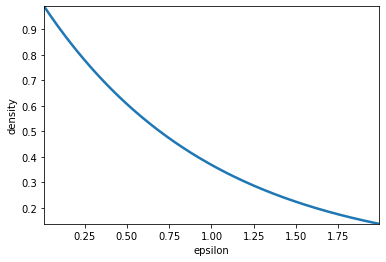

In [2]:
epsilons = torch.arange(0.0, 2, 0.01)
plt.plot(epsilons, dist.Gamma(1,1).log_prob(epsilons).exp())
plt.xlabel("epsilon")
plt.ylabel("density");

We can implement this model in Bean Machine by defining random variable objects with the `@bm.random_variable` decorator. These functions behave differently than ordinary Python functions.

<div style="background: #daeaf3; border-left: 3px solid #2980b9; display: block; margin: 16px 0; padding: 12px;">
  Semantics for <code>@bm.random_variable</code> functions:
  <ul>
    <li>They must return PyTorch <code>Distribution</code> objects.
    <li>Though they return distributions, callees actually receive <i>samples</i> from the distribution. The machinery for obtaining samples from distributions is handled internally by Bean Machine.
    <li>Inference runs the model through many iterations. During a particular inference iteration, a distinct random variable will correspond to exactly one sampled value: <b>calls to the same random variable function with the same arguments will receive the same sampled value within one inference iteration</b>. This makes it easy for multiple components of your model to refer to the same logical random variable.
    <li>Consequently, to define distinct random variables that correspond to different sampled values during a particular inference iteration, an effective practice is to add a dummy "indexing" parameter to the function. Distinct random variables can be referred to with different values for this index.
    <li>Please see the documentation for more information about this decorator.
  </ul>
</div>

In [3]:
@bm.random_variable
def beta_1():
    return dist.Normal(0, 10)

@bm.random_variable 
def beta_0():
    return dist.Normal(0, 10)

@bm.random_variable
def epsilon():
    return dist.Gamma(1, 1)

@bm.random_variable
def y(X):
    return dist.Normal(beta_1() * X + beta_0(), epsilon())

## Data

With the model defined, we need to collect some observed data in order to learn about values of interest in our model.

In this case, we will observe a few samples of inputs and outputs. For demonstrative purposes, we will use a synthetically generated dataset of observed values. In practice, you would gather a collection of covariate and response variables, and then you could construct a model to predict a new, unobserved response variable from a new, observed covariate.

For our synthetic dataset, we will assume the following parameters to the relationship between inputs and outputs.

In [4]:
N = 200

X = dist.Normal(0, 1).expand([N, 1]).sample()
true_beta_1 = 2.
true_beta_0 = 5.
true_epsilon = 1.
Y = dist.Normal(true_beta_1 * X + true_beta_0, true_epsilon).sample()

We can visualize the data as follows:

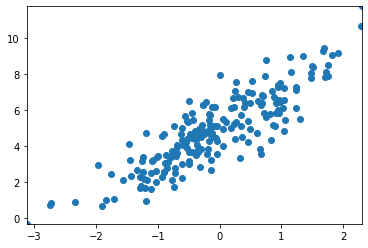

In [5]:
plt.scatter(X, Y);

Let's split the dataset into a training and test set, which we'll use later to evaluate predictive performance.

In [6]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y)

Our inference algorithms expect observations in the form of a dictionary. This dictionary should consist of `@bm.random_variable` invocations as keys, and tensor data as values.

You can see this in the code snippet below, where we bind the observed values to a key representing the random variable that was observed.

In [7]:
observations = { y(X_train): Y_train }

## Inference: Take 1

Inference is the process of combining _model_ with _data_ to obtain _insights_, in the form of probability distributions over values of interest. Bean Machine offers a powerful and general inference framework to enable fitting arbitrary models to data.

As a starting point for running inference, we will use the basic Metropolis-Hastings inference algorithm. Ancestral Metropolis-Hastings is a simple inference algorithm, which proposes child random variables conditional on values for the parent random variables. The most ancestral random variables are simply sampled from the prior distribution.

Running inference consists of a few arguments:

| Name | Usage
| --- | ---
| `queries` | A list of `@bm.random_variable` targets to fit posterior distributions for.
| `observations` | The `Dict` of observations we built up, above.
| `num_samples` | Number of samples to build up distributions for the values listed in `queries`.
| `num_chains` | Number of separate inference runs to use. Multiple chains can verify inference ran correctly.

Let's run inference:

In [8]:
samples_mh = bm.SingleSiteAncestralMetropolisHastings().infer(
    queries=[ beta_1(), beta_0(), epsilon() ],
    observations=observations,
    num_samples=2000,
    num_chains=4,
)

Samples collected:   0%|          | 0/2000 [00:00<?, ?it/s]

Samples collected:   0%|          | 0/2000 [00:00<?, ?it/s]

Samples collected:   0%|          | 0/2000 [00:00<?, ?it/s]

Samples collected:   0%|          | 0/2000 [00:00<?, ?it/s]

## Analysis: Take 1

`samples` now contains our inference results.

In [9]:
beta_0_marginal = samples_mh[ beta_0() ].flatten(start_dim=0, end_dim=1).detach()
beta_1_marginal = samples_mh[ beta_1() ].flatten(start_dim=0, end_dim=1).detach()
epsilon_marginal = samples_mh[ epsilon() ].flatten(start_dim=0, end_dim=1).detach()

print(
    f"beta_0_marginal: {beta_0_marginal}\n"
    f"beta_1_marginal: {beta_1_marginal}\n"
    f"epsilon_marginal: {epsilon_marginal}"
)

beta_0_marginal: tensor([4.2253e-03, 4.2253e-03, 4.2253e-03,  ..., 4.9422e+00, 4.9422e+00,
        4.9422e+00])
beta_1_marginal: tensor([0.5615, 0.5615, 0.5615,  ..., 1.7896, 1.7896, 1.7896])
epsilon_marginal: tensor([1.7924, 1.7924, 1.7924,  ..., 0.9710, 0.9710, 0.9710])


Next, let's visualize the inferred random variables.

In [10]:
def plot_marginal(
    variable_name,
    marginal_0,
    marginal_0_true_value=None,
    marginal_1=None,
    marginal_1_true_value=None,
):
    marginal_0 = marginal_0.squeeze()
    if len(marginal_0.shape) != 1:
        raise ValueError(
            f"Expected: marginal_0 has shape [:].\n"
            f"Actual: marginal_0 has shape {marginal_0.shape}."
        )
    
    if marginal_1 is None:
        plt.title(f"{variable_name} marginal")
        plt.hist(marginal_0, density=True)
        if marginal_0_true_value is not None:
            plt.axvline(x=marginal_0_true_value, label="True value", color="k")
        plt.axvline(x=marginal_0.mean(), label="Posterior mean", color="c")
        plt.xlabel(variable_name)
        plt.ylabel("density")
        plt.legend()
        
    else:
        marginal_1 = marginal_1.squeeze()
        if len(marginal_1.shape) != 1:
            raise ValueError(
                f"Expected: marginal_1 has shape [:].\n"
                f"Actual: marginal_1 has shape {marginal_1.shape}."
            )
        
        plt.suptitle(f"{variable_name} marginal", fontsize=20)
        
        grid = mpl.gridspec.GridSpec(4, 4)

        plt.subplot(grid[1:, :3])
        plt.hist2d(marginal_0.tolist(), marginal_1.tolist(), bins=60, density=True)
        if marginal_0_true_value is not None and marginal_1_true_value is not None:
            plt.plot(marginal_0_true_value, marginal_1_true_value, "wo", label="True value")
        plt.plot(marginal_0.mean(), marginal_1.mean(), "co", label="Posterior marginal mean")
        plt.xlabel(f"{variable_name}[0]")
        plt.ylabel(f"{variable_name}[1]")
        plt.legend()

        plt.subplot(grid[0, :3])
        plt.hist(marginal_0, density=True)
        if marginal_0_true_value is not None:
            plt.axvline(marginal_0_true_value, color="k")
        plt.axvline(marginal_0.mean(), color="c")
        plt.ylabel("density")
        plt.gca().axes.get_xaxis().set_ticklabels([])
        plt.margins(0)

        plt.subplot(grid[1:, 3])
        plt.hist(marginal_1, density=True, orientation="horizontal")
        if marginal_1_true_value is not None:
            plt.axhline(marginal_1_true_value, color="k")
        plt.axhline(marginal_1.mean(), color="c")
        plt.xlabel("density")
        plt.gca().axes.get_yaxis().set_ticklabels([])
        plt.margins(0)

    plt.show()

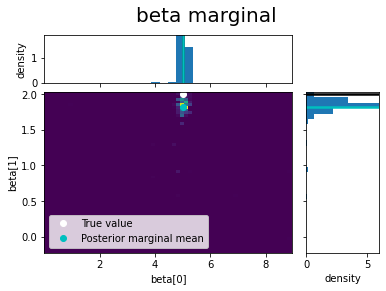

In [11]:
plot_marginal("beta", beta_0_marginal, true_beta_0, beta_1_marginal, true_beta_1)

We seem to have faithfully recovered $\beta_0$ but not $\beta_1$. It's possible that our prior was too strong relative to the small amount of data.

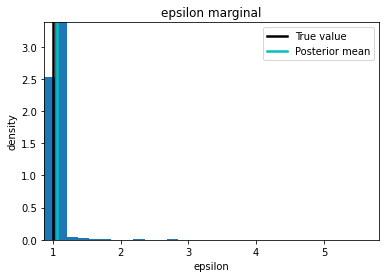

In [12]:
plot_marginal("epsilon", epsilon_marginal, true_epsilon)

We seem to have recovered a reasonably good understanding of the variance.

We can also compute log probability on the held-out test data. This isn't particularly useful on its own, but is useful for comparing different approaches. Thus, here, we will also plot a baseline for comparison: the log probability implied on the test dataset using the ground truth parameters.

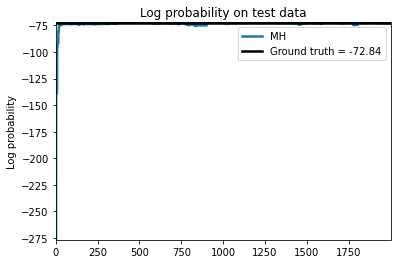

In [13]:
test_log_prob_mh = dist.Normal(
    X_test @ beta_1_marginal[:2000].unsqueeze(0) + beta_0_marginal[:2000].unsqueeze(0),
    epsilon_marginal[:2000],
).log_prob(Y_test).sum(dim=0)

test_log_prob_ground_truth = dist.Normal(
    X_test * true_beta_1 + true_beta_0,
    true_epsilon,
).log_prob(Y_test).sum(dim=0).item()

plt.title("Log probability on test data")
plt.plot(test_log_prob_mh, label="MH")
plt.axhline(test_log_prob_ground_truth, label=f"Ground truth = {test_log_prob_ground_truth:.2f}", color="k")
plt.ylabel("Log probability")
plt.legend();

While the model doesn't seem to look healthy overall, it does at least seem to capture the log probability using the ground truth parameters.

Bean Machine provides a Diagnostics package that provides helpful statistics about the results of inference. We can query this information as follows:

In [14]:
bm.Diagnostics(samples_mh).summary()

,avg,std,2.5%,50%,97.5%,r_hat,n_eff
beta_0()[],5.026,0.260,4.808,5.013,5.300,1.009,249.259
beta_1()[],1.821,0.163,1.589,1.841,1.974,1.043,60.331
epsilon()[],1.065,0.207,0.929,1.051,1.216,1.010,310.295


The summary output shows two diagnostic statistics: [$\hat{R}$](https://projecteuclid.org/euclid.ss/1177011136) (`r_hat`) and [$N_\text{eff}$](https://www.mcmchandbook.net/HandbookChapter1.pdf) (effective sample size, `n_eff`).

  * $\hat{R} \in [1, \infty)$ summarizes how effective inference was at converging on the correct posterior distribution for a particular random variable. It uses information from all chains run in order to assess whether inference had a good understanding of the distribution or not. Values very close to zero indicate that all chains discovered similar distributions for a particular random variable. We do not recommend using inference results where $\hat{R} > 1.1$, as inference may not have converged. In that case, you may want to run inference for more samples.
  * $N_\text{eff} \in [1, \texttt{num}\_\texttt{samples}]$ summarizes how independent posterior samples are from one another. Although inference was run for `num_samples` iterations, it's possible that those samples were very similar to each other (due to the way inference is implemented), and may not each be representative of the full posterior space. Larger numbers are better here, and if your particular use case calls for a certain number of samples to be considered, you should ensure that $N_\text{eff}$ is at least that large.
  
In this case, both $\hat{R}$ and $N_\text{eff}$ leave something to be desired.

Bean Machine can also plot diagnostical information to assess model fit. Let's take a look:

In [15]:
bm.Diagnostics(samples_mh).plot(display=True);

The diagnostics output shows two diagnostic plots for individual random variables: trace plots and autocorrelation plots.

  * Trace plots are simply a time series of values assigned to random variables over each iteration of inference. The concrete values assigned are usually problem-specific. However, it's important that these values are "mixing" well over time. This means that they don't tend to get stuck in one region for large periods of time, and that each of the chains ends up exploring the same space as the other chains throughout the course of inference.
  * Autocorrelation plots measure how predictive the last several samples are of the current sample. Autocorrelation may vary between -1.0 (deterministically anticorrelated) and 1.0 (deterministically correlated). (We compute autocorrelation approximately, so it may sometimes exceed these bounds.) In an ideal world, the current sample is chosen independently of the previous samples: an autocorrelation of zero. This is not possible in practice, due to stochastic noise and the mechanics of how inference works.

From the trace plots, we see each of the chains are relatively healthy: they don't get stuck, and do not explore a chain-specific subset of the space. However, the trace plots are fairly "blocky", indicating that many traces are waste due to too low of an acceptance rate for new parameter values.

Let's see if we can do better by using another inference approach.

## Inference: Take 2

To improve upon our first attempt, let's use gradient information to help guide the sampling process. Since this model is comprised entirely of differentiable random variables, we'll make use of the Newtonian Monte Carlo (NMC) inference method. NMC is a second-order method, which uses the Hessian to automatically scale the step size in each dimension.

In [16]:
samples_nmc = bm.SingleSiteNewtonianMonteCarlo().infer(
    queries=[ beta_1(), beta_0(), epsilon() ],
    observations=observations,
    num_samples=2000,
    num_chains=4,
)

Samples collected:   0%|          | 0/2000 [00:00<?, ?it/s]

Samples collected:   0%|          | 0/2000 [00:00<?, ?it/s]

Samples collected:   0%|          | 0/2000 [00:00<?, ?it/s]

Samples collected:   0%|          | 0/2000 [00:00<?, ?it/s]

## Analysis: Take 2

In [17]:
beta_0_marginal = samples_nmc[ beta_0() ].flatten(start_dim=0, end_dim=1).detach()
beta_1_marginal = samples_nmc[ beta_1() ].flatten(start_dim=0, end_dim=1).detach()
epsilon_marginal = samples_nmc[ epsilon() ].flatten(start_dim=0, end_dim=1).detach()

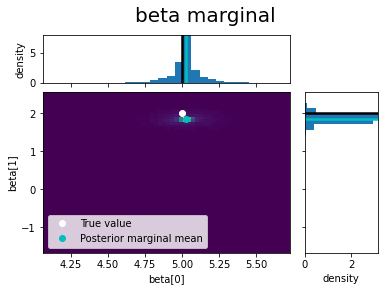

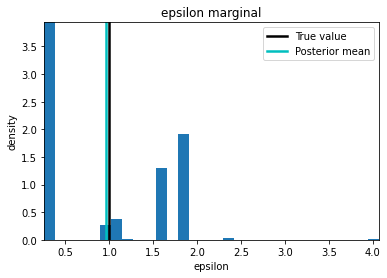

In [18]:
plot_marginal("beta", beta_0_marginal, true_beta_0, beta_1_marginal, true_beta_1)
plot_marginal("epsilon", epsilon_marginal, true_epsilon)

The marginal distributions look much healthier than with the Metropolis-Hastings approach. However, $\beta_1$ still attenuates to zero more than expected. This is possibly good evidence that our prior is having a strong influence.

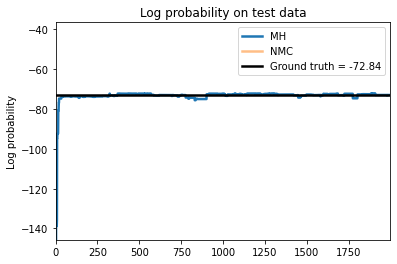

In [19]:
test_log_prob_nmc = dist.Normal(
    X_test @ beta_1_marginal[:2000].unsqueeze(0) + beta_0_marginal[:2000].unsqueeze(0),
    epsilon_marginal[:2000],
).log_prob(Y_test).sum(dim=0)

plt.title("Log probability on test data")
plt.plot(test_log_prob_mh, label="MH")
plt.plot(test_log_prob_nmc, label="NMC", alpha=0.5)
plt.axhline(test_log_prob_ground_truth, label=f"Ground truth = {test_log_prob_ground_truth:.2f}", color="k")
plt.ylabel("Log probability")
plt.ylim(test_log_prob_ground_truth * 2, test_log_prob_ground_truth / 2)
plt.legend();

NMC seems to have a very healthy log probability, and it successfully captures the log probability implied by the ground truth parameters on the test dataset.

Lastly, let's look at the diagnostics.

In [20]:
bm.Diagnostics(samples_nmc).summary()

,avg,std,2.5%,50%,97.5%,r_hat,n_eff
beta_0()[],5.027,0.101,4.809,5.026,5.253,1.000,5680.808
beta_1()[],1.858,0.112,1.642,1.856,2.086,1.001,4523.976
epsilon()[],0.963,0.690,0.259,0.460,1.875,5.894,2.101


In [21]:
bm.Diagnostics(samples_nmc).plot(display=True);

All the diagnostics look healthy. Looks like we have a winner!

## Prediction

We've built and evaluated our model. Lastly, let's take a quick look at how to predict with it.

In [22]:
def predict(x):
    x = tensor(x).float()
    return pd.DataFrame(
        np.percentile(
            dist.Normal(
                x.view([-1, 1]) @ beta_1_marginal.unsqueeze(0) + beta_0_marginal.unsqueeze(0),
                epsilon_marginal.unsqueeze(0),
            ).sample([10]).transpose(0, 1).flatten(1),
            [2.5, 50, 97.5],
            axis=1,
        ).T,
        index=x.view(-1).numpy(),
        columns=['2.5%', '50%', '97.5%'],
    )

Predict for a single value:

In [23]:
predict(4)

,2.5%,50%,97.5%
4.0,9.628,12.451,15.345


Or for a range:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



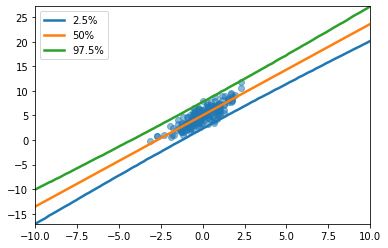

In [24]:
predict(torch.linspace(-10, 10, 100)).plot()
plt.scatter(X, Y, alpha=0.5);

## BMGInference

Bean Machine Graph (BMG) Inference is an experimental feature of the Bean Machine framework that aims to deliver higher performance for specialized models. The model used in this tutorial represents a static probabilistic graph model and happens to use only features within the language subset supported by BMGInference. As a reference point, the following code reports the time it takes for our basic implementation of NMC to compute the posterior:


In [25]:
%%time
samples_nmc = bm.SingleSiteNewtonianMonteCarlo().infer(
    queries=[ beta_1(), beta_0(), epsilon() ],
    observations=observations,
    num_samples=2000,
    num_chains=4,
)

Samples collected:   0%|          | 0/2000 [00:00<?, ?it/s]

Samples collected:   0%|          | 0/2000 [00:00<?, ?it/s]

Samples collected:   0%|          | 0/2000 [00:00<?, ?it/s]

Samples collected:   0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 1min 36s, sys: 869 ms, total: 1min 37s
Wall time: 1min 38s


To run our model using BMGInference, the only change needed is the following:

In [26]:
%%time
from beanmachine.ppl.inference.bmg_inference import BMGInference

samples_nmc = BMGInference().infer(
    queries=[ beta_1(), beta_0(), epsilon() ],
    observations=observations,
    num_samples=2000,
    num_chains=4,
)

CPU times: user 3.97 s, sys: 14.9 ms, total: 3.98 s
Wall time: 3.51 s


Wall time numbers will naturally vary on different platforms, but with with these parameters (model, observations, queries, sample size, and number of chains) speedup on the author's machine is about 60x. Generally speaking, larger speedups are expected with larger sample sizes. More information about BMGInference can be found on the website in "Advanced" section of the documentation.